In [57]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest

import pandas as pd
import sqlalchemy
from collections import defaultdict
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import datetime
import importlib
from simulator.magnetic import SimulatorMagnetic
from simulator.models import Client, Simulation
from tqdm.notebook import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

import logging.config
import logging
import sys, os
logging.config.fileConfig(os.environ["HOME"]+"/telegramLogConfig")
logger = logging.getLogger("telegram")

matplotlib.rcParams["figure.dpi"] = 150

client = Client()

In [2]:
with client.Session() as session:
    query = (session.query(Simulation.id)
                 .where(Simulation.group_name=='Ensemble 3')
                 .where(Simulation.Bz == 0)
                 .order_by(Simulation.start_time)).all()[:]
print(len(query))

32


In [3]:
sims = []
for sid, in tqdm(query):
    sims.append(
        SimulatorMagnetic(id=sid)
    )

  0%|          | 0/32 [00:00<?, ?it/s]

In [4]:
data = []
rs = []
ies = []
pes = []
for sim in tqdm(sims):
    rs.append(sim.get_history()["rs"].transpose(0,2,1).reshape(-1,3))
    ies.append(sim.get_history()["IE"].flatten())
    pes.append(sim.get_history()["PE"].flatten())
rs = np.sum(np.concatenate(rs)[:,:2]**2,axis=-1)**0.5
ies = np.concatenate(ies)
pes = np.concatenate(pes)

  0%|          | 0/32 [00:00<?, ?it/s]

In [35]:
df = pd.DataFrame({"R":rs, "IE":ies, "PE":pes})
df = df.sort_values("R")
# df = df.set_index("R")
df = df.reset_index(drop=True)

In [41]:
dr = 0.01
gb = df.groupby((df.R/dr).astype(int))

In [45]:
df_sp = gb.mean().set_index("R")

<AxesSubplot:xlabel='R'>

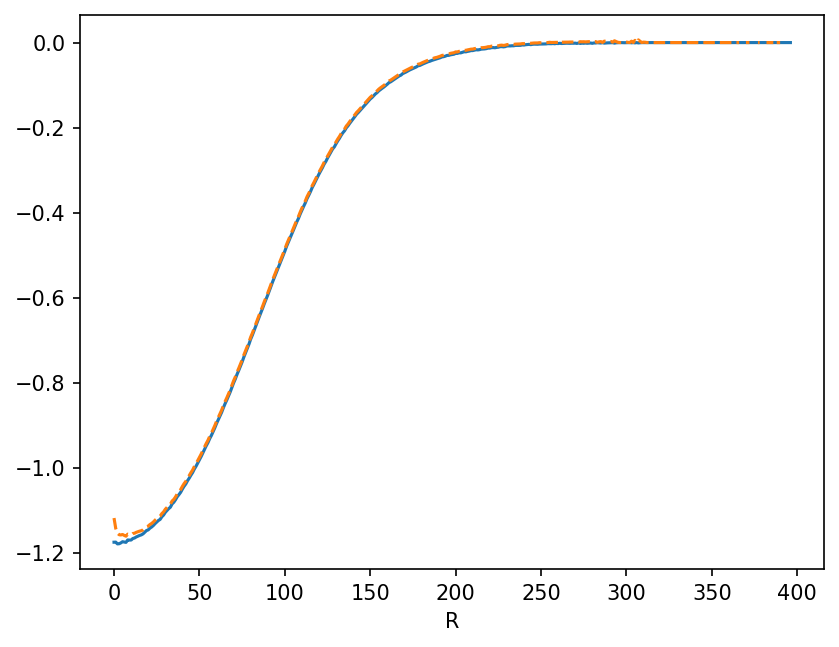

In [58]:
gb.IE.mean().plot()
(gb.IE.mean()+10*gb.IE.std()/gb.IE.count()**0.5).plot(style="--")

In [66]:
len(df_sp)

390

In [98]:
from scipy.interpolate import UnivariateSpline
spl_IE = UnivariateSpline(df_sp.index, df_sp.IE, k=5, s=0.0001)
spl_PE = UnivariateSpline(df_sp.index, df_sp.PE, k=5, s=1)

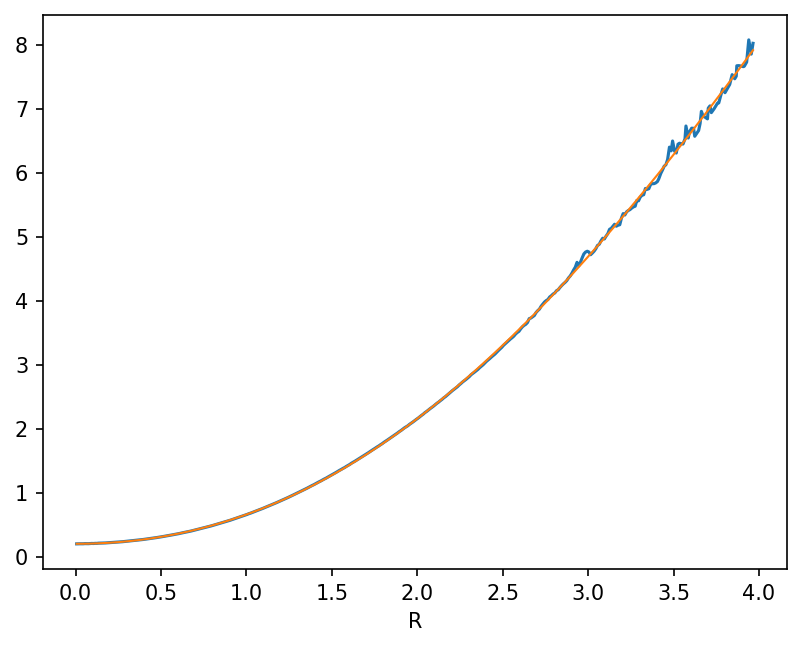

In [99]:
df_sp.PE.plot()
plt.plot(df_sp.index, spl_PE(df_sp.index), lw=1)

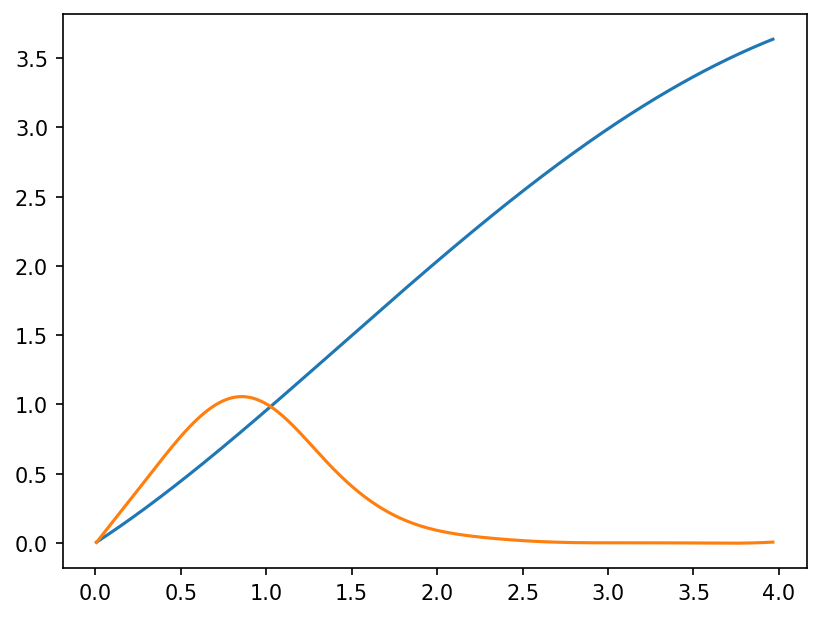

In [101]:
plt.plot(df_sp.index, spl_PE.derivative(1)(df_sp.index))
plt.plot(df_sp.index, spl_IE.derivative(1)(df_sp.index))

In [31]:
dfs.keys()

dict_keys(['L', 'KE', 'PE', 'IE', 'BInertia'])

In [37]:
def f(id):
    id = id[0]
    sim = SimulatorMagnetic(id=id)
    name = sim.name
    Bz = sim.Bz
    dfs = sim.get_data_frames()
    data = dict()
    
    for key in ["L", "KE", "PE", "IE"]:
        data[key] = pd.Series(dfs[key].sum(axis=1), name=name)
    data["E"] = pd.Series((dfs["KE"] + dfs["PE"] + 0.5*dfs["IE"]).sum(axis=1), name=name)
    data["col"] = pd.Series(sim.get_history()["collisions"],name=name)
    return Bz, data

In [38]:
pool = multiprocessing.Pool(cpu_count(), maxtasksperchild=1)

In [22]:
query = (session.query(Simulation.id)
             .where(Simulation.group_name=='Armen init 5 (dummy)')
#              .where(Simulation.record_interval==0.1)
             .where(Simulation.iterations > 10000)
             .order_by(Simulation.start_time)).all()[:]
print(len(query))

169


In [ ]:
pool_result = list(tqdm(pool.imap(f, query), total=len(query)))

data = defaultdict(lambda : defaultdict(list))
for Bz, item in pool_result:
    for key, value in item.items():
        data[Bz][key].append(value)
for Bz in data.keys():
        for key in data[Bz].keys():
            df = pd.concat(data[Bz][key], axis=1)
            data[Bz][key] = df
data = dict(data)

In [41]:
index = data[0]["L"].index

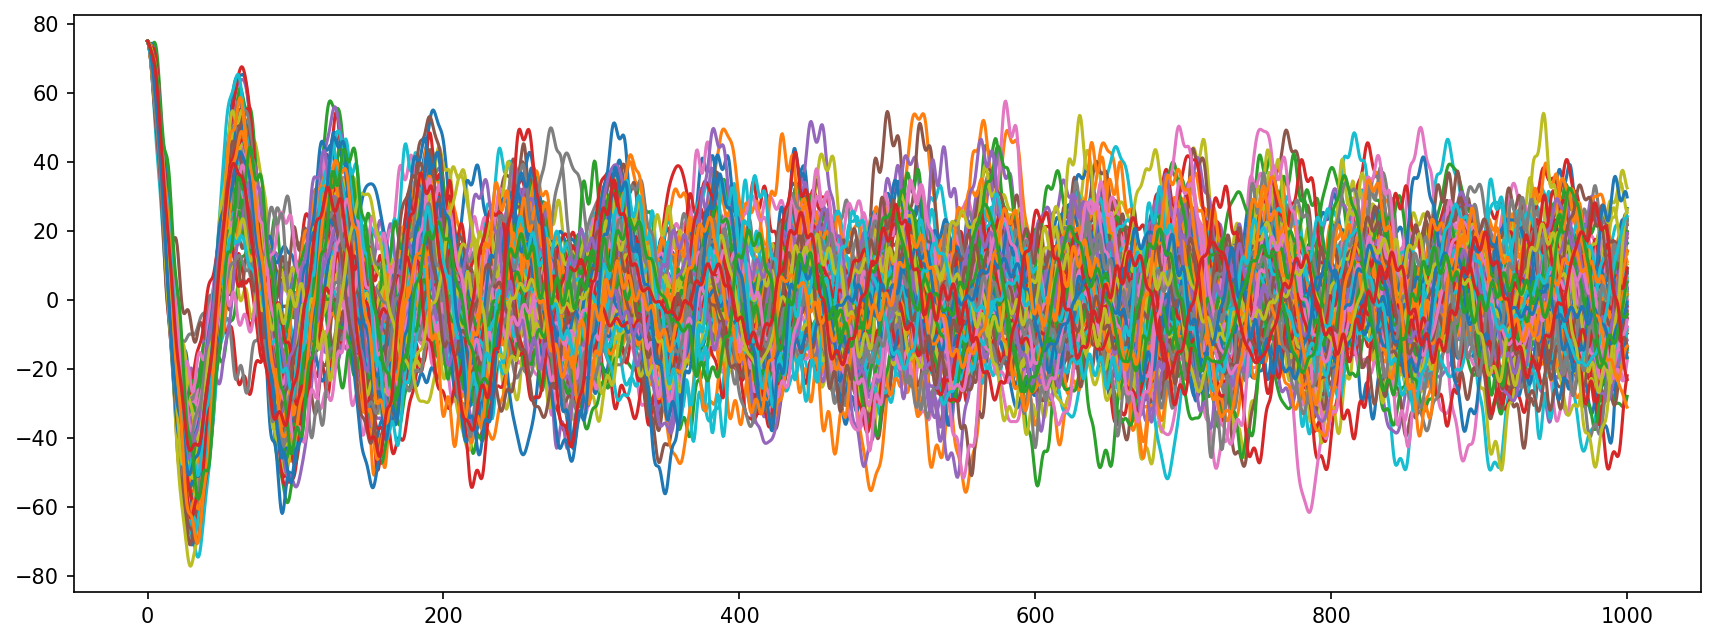

In [63]:
fig = plt.figure(figsize=(14,5))
data[0]["L"].loc[:1000].plot(ax=plt.gca())
plt.gca().get_legend().remove()

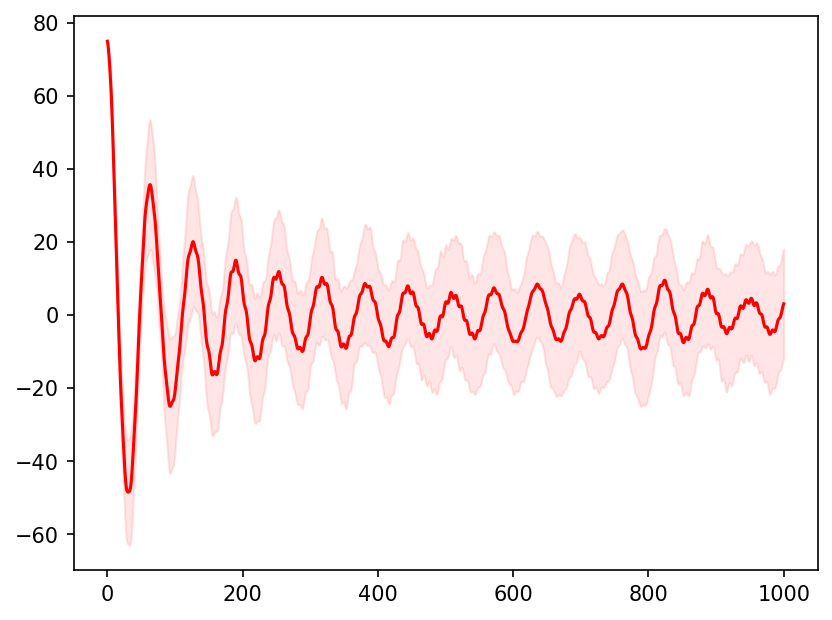

In [62]:
plot_mean_std(data[0]["L"].loc[:1000],"r","")

In [58]:
def plot_mean_std(df, color, label):
    m = df.mean(axis=1)
    std = df.std(axis=1)
    m.plot(color=color, label=label)
    plt.fill_between(df.index, (m + std), (m - std), color=color, alpha=0.1)

In [14]:
df_diff = {}
for Bz in data.keys():
    if Bz==0:
        continue
    sr = (data[Bz]["L"]-data[0]["L"])[data[Bz]["L"].columns[0]]
    sr.name = Bz
    df_diff[Bz] = sr
df_diff = pd.DataFrame(df_diff)

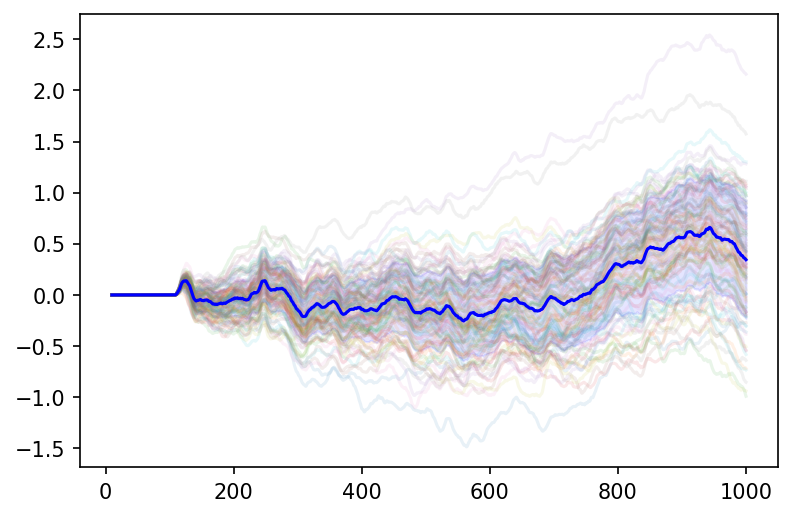

In [15]:
rl = 100
ax = df_diff.rolling(rl).mean().plot(alpha=0.1)
ax.get_legend().remove()
plot_mean_std(df_diff.rolling(rl).mean(), "blue", "a")

In [ ]:
fig = plt.figure(figsize=(14,5))
ax = plt.gca()
data[0]["L"].plot(alpha=0.1, color="blue", ax=ax)
data[1e-7]["L"].plot(alpha=0.1, color="orange", ax=ax)

# plt.xlim(-0.5, 1)
plt.grid()
ax.get_legend().remove()

In [ ]:
fig = plt.figure(figsize=(14,5))
plot_mean_std(data[0]["L"], color="blue", label=r"$B=0$")
plot_mean_std(data[1e-7]["L"], color="orange", label=r"$B\ne 0$")
plot_mean_std(data[1]["L"], color="red", label=r"$B\ne 0$")

# plt.xlim(-0.5, 1)
plt.grid(which="both")
plt.minorticks_on()
plt.legend()
# ax.get_legend().remove()

In [13]:
100/12

8.333333333333334

In [19]:
index[1]

0.05

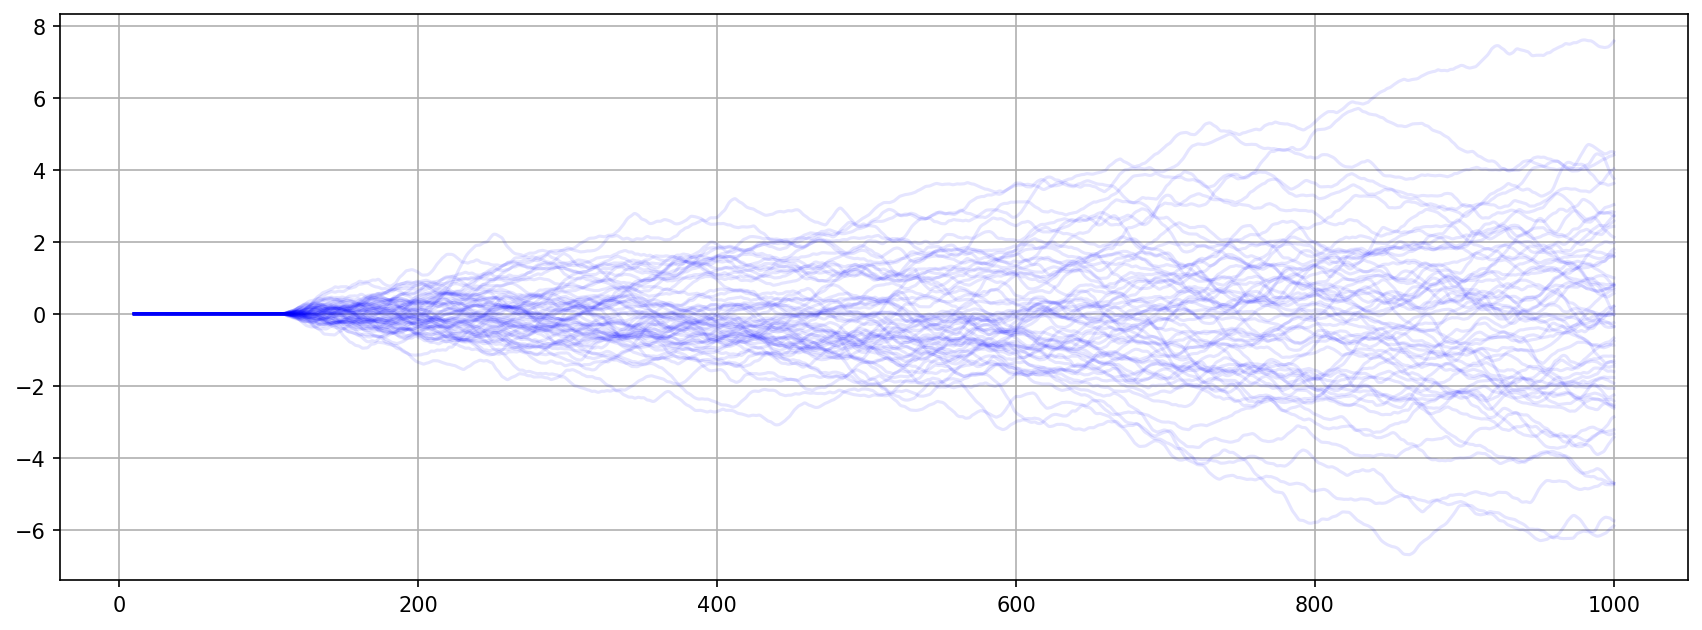

In [24]:
rl = int(10/0.05)
fig = plt.figure(figsize=(14,5))
ax = plt.gca()

(data[1e-7]["L"]-data[0]["L"]).rolling(rl).mean().plot(alpha=0.1, color="blue", ax=ax)

# plt.xlim(-0.5, 1)
plt.grid()
ax.get_legend().remove()

In [29]:
@interact(t=IntSlider(min=0, max=500, step=10, 
                       continuous_update=False))
def f(t):
    L[0].loc[t].plot.kde()
    L[1e-7].loc[t].plot.kde()


interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=500, step=10), Output()…

In [12]:
diff = data[1e-7]["L"] - data[0]["L"]

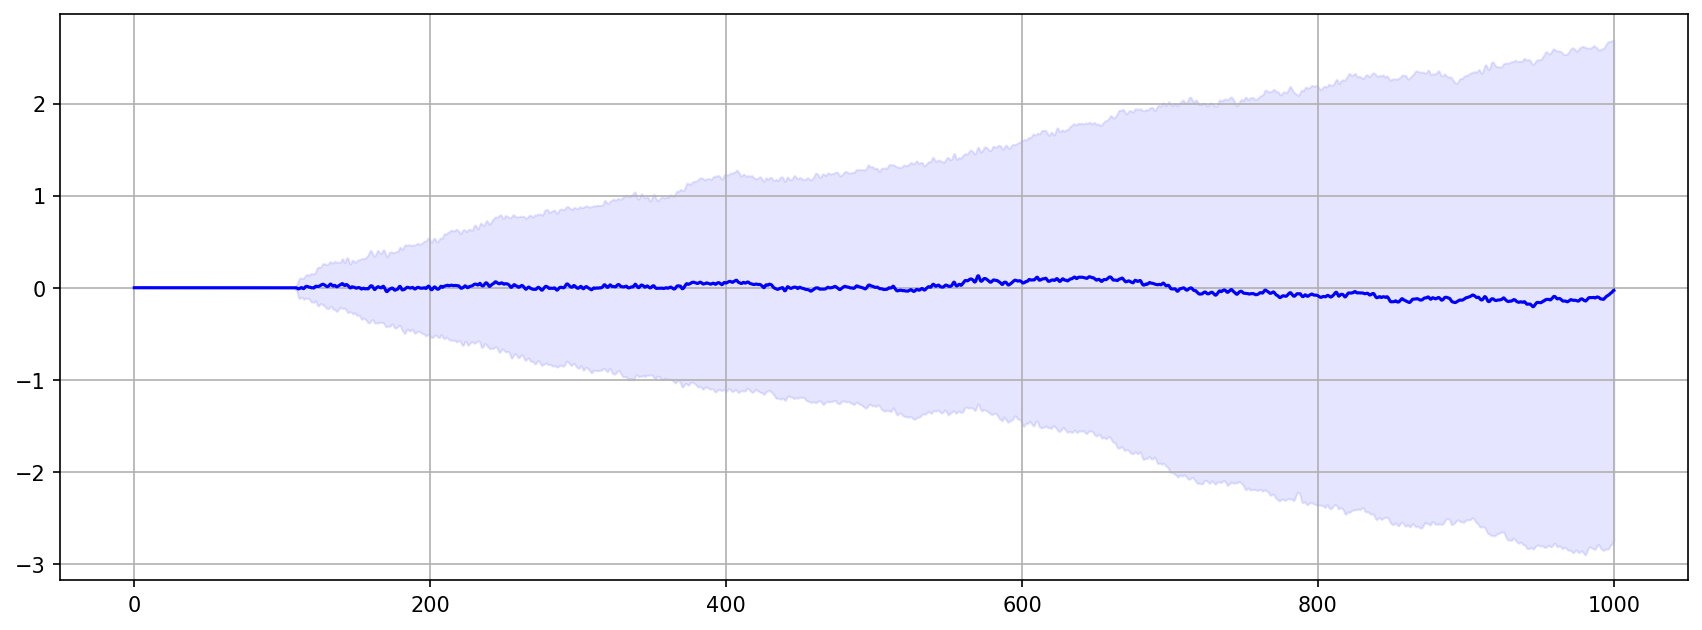

In [13]:
fig = plt.figure(figsize=(14,5))
plot_mean_std(diff.loc[:], color="blue", label=r"diff")
plt.grid()

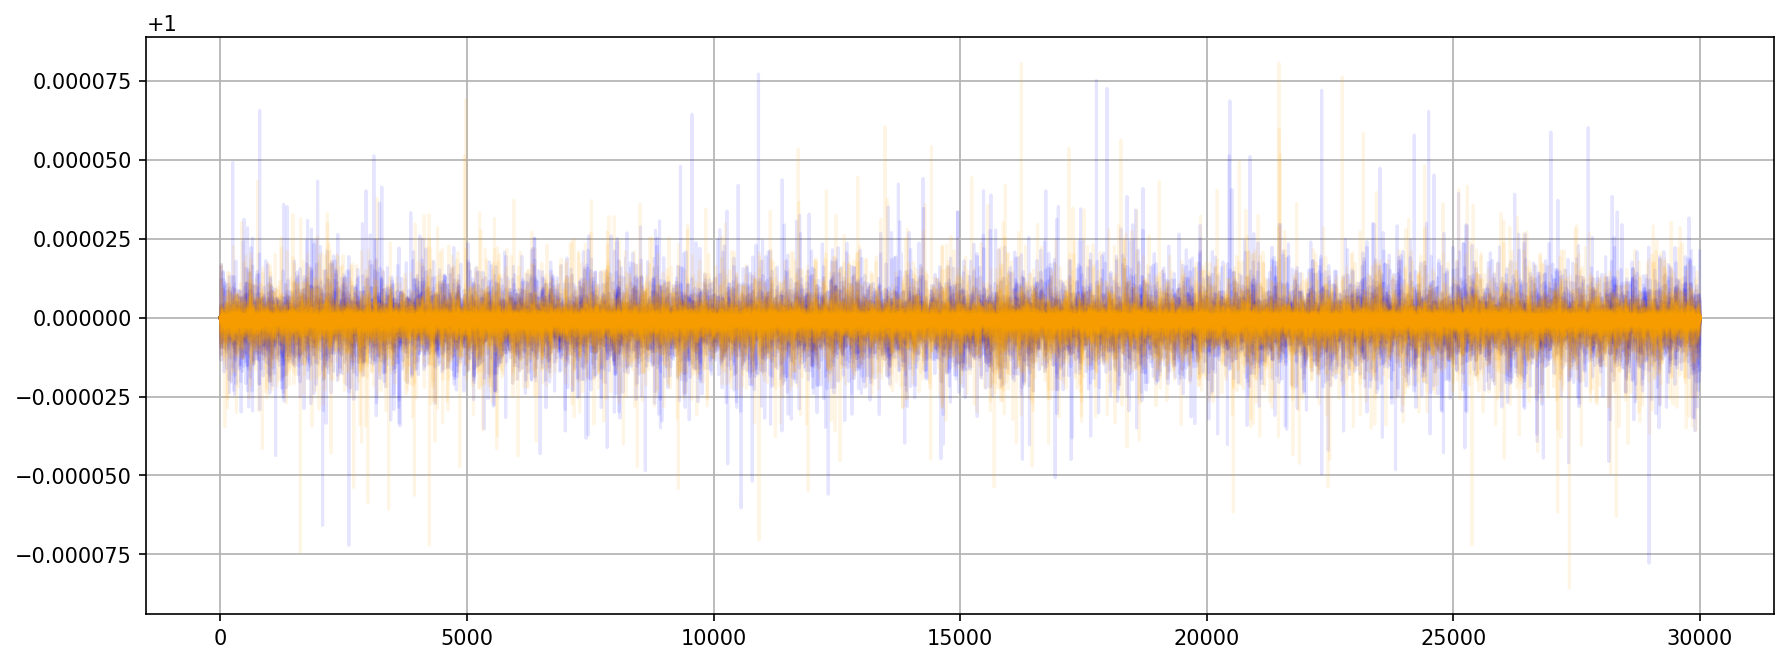

In [43]:
fig = plt.figure(figsize=(14,5))
ax = plt.gca()
(data[0]["E"]/data[0]["E"].iloc[0]).plot(alpha=0.1, color="blue", ax=ax)
(data[1e-7]["E"]/data[1e-7]["E"].iloc[0]).plot(alpha=0.1, color="orange", ax=ax)

# L[2].plot(alpha=0.1, color="orange", ax=ax)
# L[2].plot(alpha=0.1, color="red", ax=ax)
# L[3].plot(alpha=0.1, color="k", ax=ax)
# L[10].plot(alpha=0.1, color="green", ax=ax)

# plt.xlim(-0.5, 1)
plt.grid()
ax.get_legend().remove()

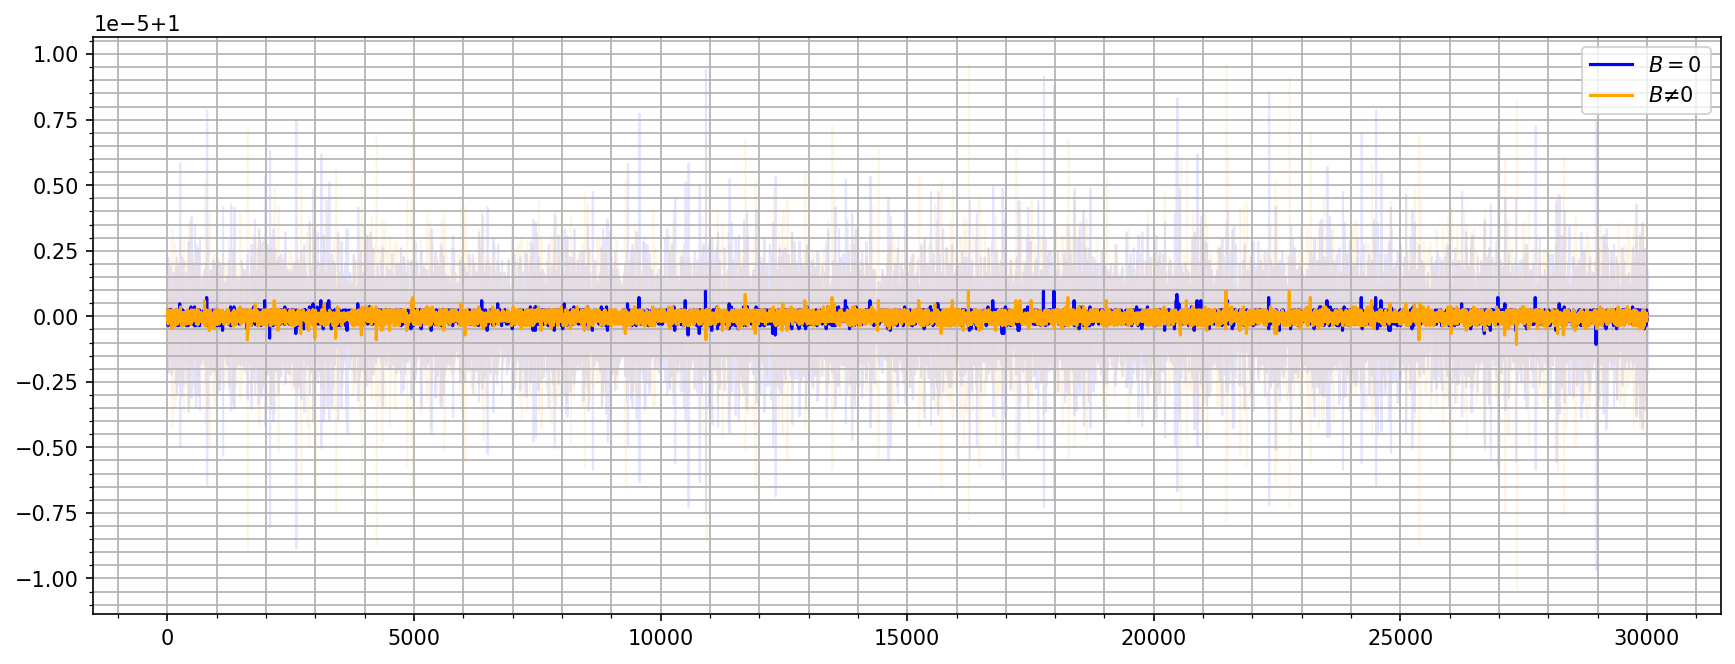

In [44]:
fig = plt.figure(figsize=(14,5))
plot_mean_std((data[0]["E"]/data[0]["E"].iloc[0]), color="blue", label=r"$B=0$")
plot_mean_std((data[1e-7]["E"]/data[1e-7]["E"].iloc[0]), color="orange", label=r"$B\ne 0$")
# plot_mean_std(data[1]["E"], color="red", label=r"$B\ne 0$")

# plt.xlim(-0.5, 1)
plt.grid(which="both")
plt.minorticks_on()
plt.legend()
# ax.get_legend().remove()